In [1]:
import xarray as xr
import xroms
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import cmocean.cm as cmo
import cf_xarray
import xcmocean
import RePlots as rp

In [2]:
# loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
fname = '/Users/kthyng/packages/xroms/examples/txla2_his_a_latest.nc'
ds = xroms.open_netcdf(fname, chunks='auto')

In [3]:
#set up plotting stuff
pc = cartopy.crs.PlateCarree()  # to match lon/lat
proj = cartopy.crs.LambertConformal(central_longitude=-90)  # projection for plot

# Run quick check plots

## Mapview annual mean of temperature

Try gridspec with constrained layout

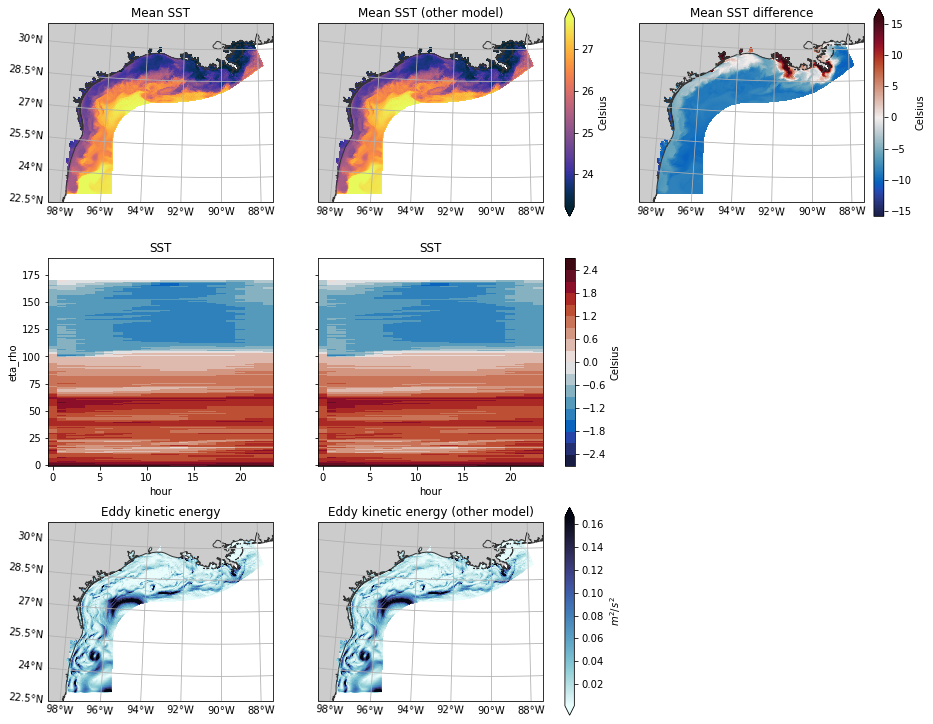

In [27]:
fig = plt.figure(figsize=(15,13))
nrows, ncols = 3, 3

## Mean SSTs ##
var = ds.temp.cf.isel(s_rho=-1).cf.mean('T', skipna=False)
var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

ax1 = plt.subplot(nrows, ncols, 1, projection=proj)
pargs, oargs = rp.setup_map(ax=ax1, title='Mean SST')
var.cmo.cfplot(**pargs, add_colorbar=False)

ax2 = plt.subplot(nrows, ncols, 2, projection=proj)
pargs, oargs = rp.setup_map(ax=ax2, left_labels=False, title='Mean SST (other model)')
var.cmo.cfplot(**pargs, cbar_kwargs=setup_cbar(label='Celsius', ax=[ax1,ax2]))

ax3 = plt.subplot(nrows, ncols, 3, projection=proj)
pargs, oargs = setup_map(ax=ax3, left_labels=False, title='Mean SST difference')  # making up new variable to show difference
(var-var2).cmo.cfplot(**pargs, cbar_kwargs=setup_cbar(label='Celsius'))


## Hovmoller ##
var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

ax4 = plt.subplot(nrows, ncols, 4)
var.cmo.plot(x='hour', y='eta_rho', ax=ax4, levels=20, add_colorbar=False)
ax4.set_title('SST')

ax5 = plt.subplot(nrows, ncols, 5)
var.cmo.plot(x='hour', y='eta_rho', ax=ax5, levels=20, cbar_kwargs=setup_cbar(ax=[ax4,ax5], label='Celsius'))
ax5.yaxis.set_ticklabels('')
ax5.set_ylabel('')
ax5.set_title('SST')


## EKE ##
var = ds.xroms.EKE.cf.mean('T', skipna=False)
ax7 = plt.subplot(nrows, ncols, 7, projection=proj)
pargs, oargs = rp.setup_map(ax=ax7, title='Eddy kinetic energy')
var.cmo.cfplot(**pargs, add_colorbar=False)

ax8 = plt.subplot(nrows, ncols, 8, projection=proj)
pargs, oargs = rp.setup_map(ax=ax8, left_labels=False, title='Eddy kinetic energy (other model)')
var.cmo.cfplot(**pargs, cbar_kwargs=setup_cbar(ax=[ax7,ax8], label='$' + var.units +'$'))


In [28]:
# plt.rcParams['figure.constrained_layout.use'] = False
# import matplotlib.gridspec as gridspec
# # fig, axes = plt.subplots(1, 2) # HAVE TO USE ADD_SUBPLOT INSTEAD TO HAVE PROJECTION CHOICES DIFFERENT IN DIFF SUBPLOTS
# fig = plt.figure(figsize=(15,13))
# gs = fig.add_gridspec(3, 3)

# ## Mean SSTs ##
# var = ds.temp.isel(s_rho=-1).cf.mean('T', skipna=False)
# var2 = ds.salt.isel(s_rho=-1).cf.mean('T', skipna=False)

# ax1 = fig.add_subplot(gs[0], projection=proj)
# pargs, oargs = setup_map(var, proj, ax=ax1)#, fig=fig, nrows=3, ncols=3)
# var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)
# pargs['ax'].set_title('Mean SST')

# ax2 = fig.add_subplot(gs[1], projection=proj)
# # ax2 = plt.subplot(3, 3, 2, projection=proj)
# pargs, oargs = setup_map(var, proj, ax=ax2, left_labels=False)
# var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius', 'ax': [ax1,ax2]})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
# pargs['ax'].set_title('Mean SST (other model)')

# ax3 = fig.add_subplot(gs[2], projection=proj)
# # ax3 = plt.subplot(3, 3, 3, projection=proj)
# pargs, oargs = setup_map( (var-var2), proj, ax=ax3, left_labels=False)  # making up new variable to show difference
# (var-var2).cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'fraction': 0.046, 'pad': 0.04,  'label': 'Celsius'})
# pargs['ax'].set_title('Mean SST difference')


# ## Hovmoller ##
# # var = ds.temp.isel(xi_rho=300,s_rho=-1).xroms.groupbytime('hour') - 25
# var = ds.temp.isel(xi_rho=300,s_rho=-1).cf.groupby("T.hour").mean(skipna=False) - 25

# ax4 = fig.add_subplot(gs[3])
# # ax4 = plt.subplot(3, 3, 4)
# cmap = choosecmap(var)  # choose colormap
# var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax4, levels=20, add_colorbar=False)
# ax4.set_title('SST')

# ax5 = fig.add_subplot(gs[4])
# # ax5 = plt.subplot(3, 3, 5)
# var.plot.contourf(x='hour', y='eta_rho', cmap=cmap, ax=ax5, levels=20, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'ax': [ax4,ax5], 'label': 'Celsius'})
# ax5.yaxis.set_ticklabels('')
# ax5.set_ylabel('')
# ax5.set_title('SST')


# ## EKE ##
# ax7 = fig.add_subplot(gs[6], projection=proj)
# # ax7 = plt.subplot(3, 3, 7, projection=proj)
# var = ds.xroms.EKE.cf.mean('T', skipna=False)
# pargs, oargs = setup_map(var, proj, ax=ax7, vmin=0, vmax=0.3)
# var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, add_colorbar=False)#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
# pargs['ax'].set_title('Eddy kinetic energy')

# ax8 = fig.add_subplot(gs[7], projection=proj)
# # ax8 = plt.subplot(3, 3, 8, projection=proj)
# pargs, oargs = setup_map(var, proj, ax=ax8, vmin=0, vmax=0.3, left_labels=False)
# var.cf.plot.pcolormesh(x='longitude', y='latitude', **pargs, cbar_kwargs={'ax': [ax7,ax8], 'label': '$' + var.units +'$'})#, cbar_kwargs={'fraction': 0.046, 'pad': 0.04, 'label': 'Celsius', 'ax': [ax1,ax2]})
# pargs['ax'].set_title('Eddy kinetic energy (other model)')

# # fig.tight_layout()
# # fig.subplots_adjust(hspace=0.3)